In [86]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

seed = 42
import numpy as np
np.random.seed(seed)
import random
random.seed(seed)

df = pd.read_csv('poetry_features.csv')

df["gender"] = df["gender"].apply(lambda x: 1 if x == "Male" else 0)

tfidf = TfidfVectorizer(max_features=500, ngram_range=(1, 3))
tfidf_matrix = tfidf.fit_transform(df['content_preprocessed'])

In [87]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

author_vectors = df.groupby('author')['content_preprocessed'].apply(
    lambda poems: np.mean(tfidf.transform(poems).toarray(), axis=0))
author_matrix = np.vstack(author_vectors.values)

similarity_matrix = cosine_similarity(author_matrix)

authors = author_vectors.index
similarity_df = pd.DataFrame(similarity_matrix, index=authors, columns=authors)
similarity_df.head()

author,AMBER TAMBLYN,ARCHIBALD MACLEISH,BRIAN TURNER,CARL SANDBURG,CHRISTOPHER MARLOWE,CONRAD AIKEN,D. H. LAWRENCE,DUCHESS OF NEWCASTLE MARGARET CAVENDISH,E. E. CUMMINGS,EDGAR LEE MASTERS,...,T. S. ELIOT,THOMAS BASTARD,THOMAS CAMPION,THOMAS HEYWOOD,THOMAS LODGE,THOMAS NASHE,WALLACE STEVENS,WILLIAM BUTLER YEATS,WILLIAM BYRD,WILLIAM SHAKESPEARE
author,,,,,,,,,,,,,,,,,,,,,
AMBER TAMBLYN,1.000000,0.010053,0.260230,0.195357,0.190570,0.010628,0.325024,0.034047,0.091259,0.248792,...,0.317153,0.103906,0.259850,0.047488,0.132673,0.069830,0.100451,0.253253,0.055003,0.176950
ARCHIBALD MACLEISH,0.010053,1.000000,0.000000,0.092150,0.000000,0.953422,0.000000,0.000000,0.400497,0.000000,...,0.000855,0.003404,0.009094,0.000000,0.000000,0.000000,0.620555,0.352381,0.000000,0.001685
BRIAN TURNER,0.260230,0.000000,1.000000,0.326987,0.328376,0.004647,0.368926,0.062249,0.093384,0.257605,...,0.391709,0.181709,0.257193,0.166197,0.107954,0.170072,0.142527,0.380897,0.043228,0.308273
CARL SANDBURG,0.195357,0.092150,0.326987,1.000000,0.237320,0.074687,0.407773,0.056668,0.214261,0.218984,...,0.346997,0.171540,0.320073,0.269222,0.159700,0.094690,0.202997,0.406689,0.055920,0.259785
CHRISTOPHER MARLOWE,0.190570,0.000000,0.328376,0.237320,1.000000,0.002641,0.321327,0.164015,0.084375,0.324837,...,0.280427,0.360709,0.441930,0.261044,0.252770,0.196428,0.164824,0.347981,0.109363,0.502310


C:\Users\Felix\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Standardabweichung innerhalb eines Clusters bzgl Geburtsjahr Autoren: 54.87995995146192 Jahre


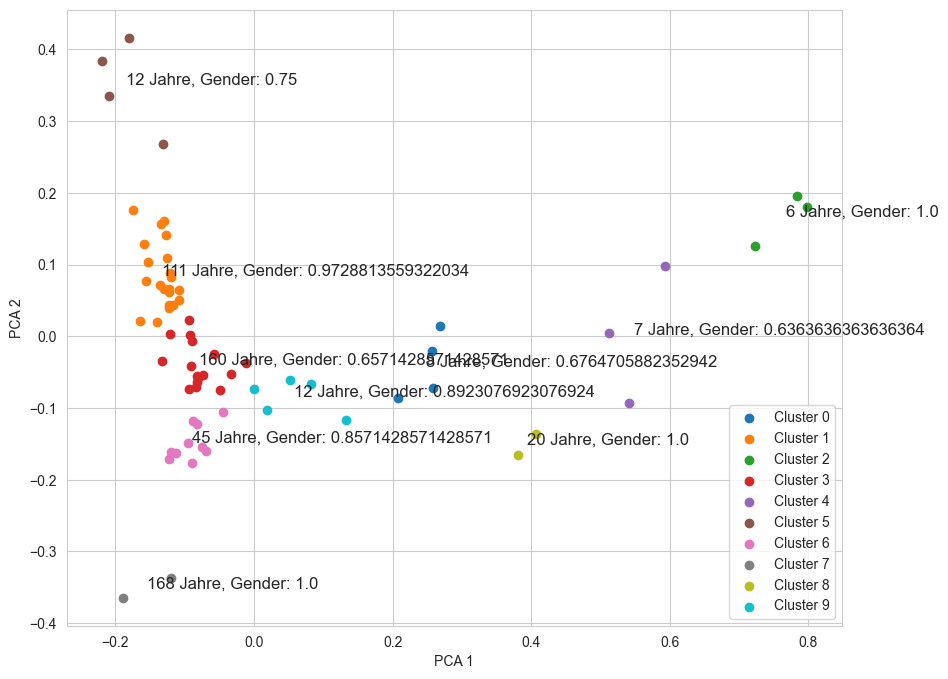

In [89]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
author_matrix_reduced = pca.fit_transform(author_matrix)

n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(author_matrix_reduced)

stds = []

plt.figure(figsize=(10, 8))
for i in range(n_clusters):
    points = author_matrix_reduced[clusters == i]
    plt.scatter(points[:, 0], points[:, 1], label=f'Cluster {i}')
    std = df[df["author"].isin(authors[clusters == i])]["birth"].unique().std()
    gender = df[df["author"].isin(authors[clusters == i])]["gender"].mean()
    stds.append(std)
    plt.text(np.mean(points[:, 0]), np.mean(points[:, 1]), f"{std:.0f} Jahre, Gender: {gender}", fontsize=12)

print(f"Standardabweichung innerhalb eines Clusters bzgl Geburtsjahr Autoren: {np.mean(stds)} Jahre")

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.savefig("clusters.png", dpi=300)
plt.show()

In [90]:
author_clusters = pd.DataFrame({'Author': authors, 'Cluster': clusters})
author_clusters.head()

,Author,Cluster
0,AMBER TAMBLYN,6
1,ARCHIBALD MACLEISH,2
2,BRIAN TURNER,6
3,CARL SANDBURG,3
4,CHRISTOPHER MARLOWE,1


In [91]:
df["cluster"] = df["author"].map(author_clusters.set_index('Author')['Cluster'])

In [95]:
author_clusters[author_clusters['Cluster'] == 2]

,Author,Cluster
1,ARCHIBALD MACLEISH,2
5,CONRAD AIKEN,2
34,KENNETH FEARING,2


In [96]:
df[df["author"].isin(author_clusters[author_clusters['Cluster'] == 1]["Author"])]["birth"].unique()

array([1564, 1552, 1572, 1460, 1587, 1561, 1525, 1491, 1503, 1554, 1509,
       1517, 1865, 1567, 1562, 1543, 1579, 1892], dtype=int64)

In [97]:
high_similarity_threshold = 0.5

# Find pairs of authors with high similarity scores
high_similarity_pairs = []
for i in range(len(similarity_df)):
    for j in range(i + 1, len(similarity_df)):
        if similarity_df.iloc[i, j] > high_similarity_threshold:
            pair = (similarity_df.index[i], similarity_df.index[j], similarity_df.iloc[i, j])
            high_similarity_pairs.append(pair)

high_similarity_pairs = sorted(high_similarity_pairs, key=lambda x: x[2], reverse=True)
ignored_authors = [
    "KENNETH FEARING",
    "GERTRUDE STEIN",
    "ARCHIBALD MACLEISH",
    "HUGH MACDIARMID",
    "EDITH SITWELL",
    "CONRAD AIKEN",
    "MALCOLM COWLEY",
    "JAMES JOYCE",
]
diff = []
for pair in high_similarity_pairs[:20]:
    if pair[0] in ignored_authors or pair[1] in ignored_authors:
        continue
    diff.append(abs(df[df["author"] == pair[0]]["birth"].values[0] - df[df["author"] == pair[1]]["birth"].values[0]))
    print(pair)
    print(df[df["author"] == pair[0]]["birth"].values[0], df[df["author"] == pair[1]]["birth"].values[0])

('JOHN DONNE', 'WILLIAM SHAKESPEARE', 0.7887841487386843)
1572 1564
('SIR PHILIP SIDNEY', 'WILLIAM SHAKESPEARE', 0.6732673822572277)
1554 1564
('THOMAS CAMPION', 'WILLIAM SHAKESPEARE', 0.6639932678049301)
1567 1564
('JOHN DONNE', 'SIR PHILIP SIDNEY', 0.6623570863960442)
1572 1554
('SAMUEL DANIEL', 'WILLIAM SHAKESPEARE', 0.6386396960189914)
1562 1564
('EN JONSON', 'JOHN DONNE', 0.6355377498995652)
1572 1572
('JOHN DONNE', 'THOMAS CAMPION', 0.6346766353367541)
1572 1567
('EDMUND SPENSER', 'WILLIAM SHAKESPEARE', 0.6040485575347264)
1552 1564
('EN JONSON', 'SIR PHILIP SIDNEY', 0.6011031297087247)
1572 1554
('EDMUND SPENSER', 'JOHN DONNE', 0.5951242032501849)
1552 1572


In [98]:
np.array(diff).mean()

9.6